In [ ]:
import numpy as np
import random
import torch
import importlib
import os

import sys
sys.path.append('./..')

from models.network import AutoEncoder, ImageAutoEncoder
from data.data import ImNetImageSamples
from utils.debugger import MyDebugger
from torch.multiprocessing import Pool, Process, set_start_method


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


## folder for testing
testing_folder = r'/path/to/train_neural_template/svr_rgbd/2023-10-31_15-34-46_Image-Training-experiment-home-AutoEncoder-IMAGE-Flow'
config_path = os.path.join(testing_folder, 'config.py')

## import config here
spec = importlib.util.spec_from_file_location('*', config_path)
config = importlib.util.module_from_spec(spec)
spec.loader.exec_module(config)

## dataload
### create dataset
data_path = r'/path/to/datasets/shapenet/ShapeNetDepthCore.v2.h5/splitted/dataset_train.hdf5'

samples = ImNetImageSamples(data_path=data_path)

In [ ]:
samples.data_voxels.shape

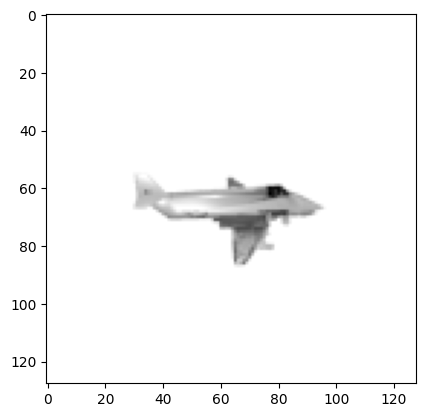

In [14]:
import matplotlib.pyplot as plt

plt.imshow(samples.data_pixels[0][2, 0], cmap='gray')

In [12]:
latent_vector_gt

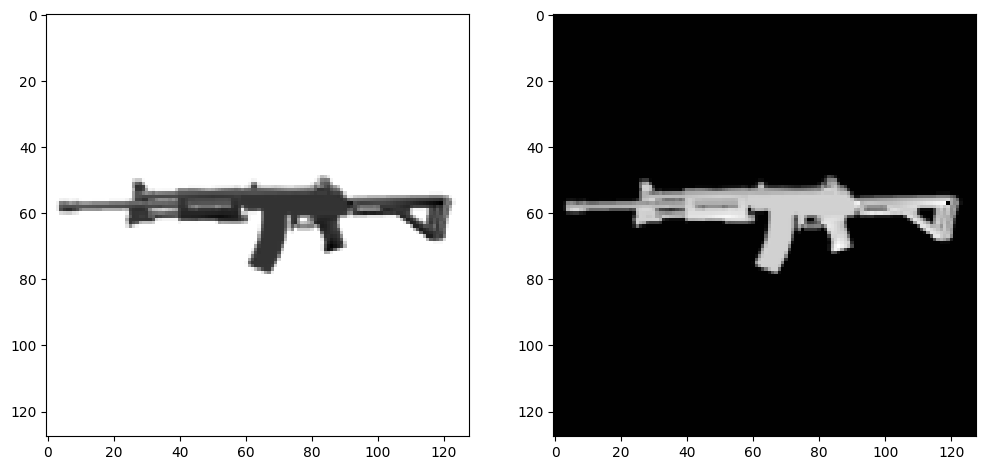

In [19]:
import matplotlib.pyplot as plt

img = samples.data_pixels[22440][2, 0].copy()

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(121)
ax.imshow(img, cmap='gray')

ax = fig.add_subplot(122)
ax.imshow(1 - img, cmap='gray')

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

In [2]:
h5_data = h5py.File('/path/to/datasets/shapenet/ShapeNetDepthCore.v2.h5/splitted/dataset_train.hdf5', 'r')
h5_data['pixels'].shape

(31742, 24, 137, 137, 3)

In [4]:
h5_data['classes'][0]

12

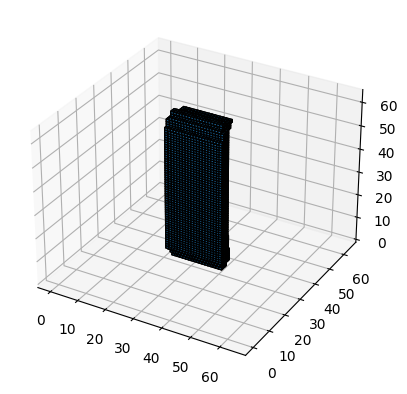

In [5]:
ax = plt.figure().add_subplot(projection='3d')
_ = ax.voxels(h5_data['voxels'][0, ..., 0], edgecolor='k')

In [6]:
h5_data['points_32'][0].mean(), h5_data['points_32'][0].std(), h5_data['points_32'][0].max(), h5_data['points_32'][0].min()

(128.050048828125, 63.35799758313872, 255, 0)

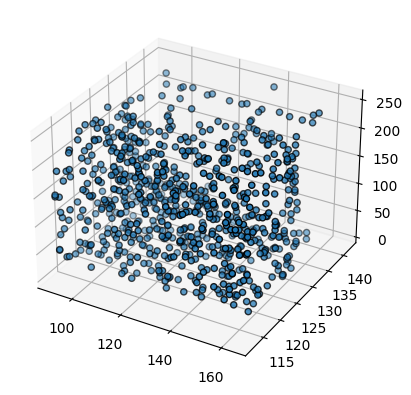

In [7]:
in_obj = h5_data['values_32'][0, :, 0] > 0.1
point_in_obj = h5_data['points_32'][0][in_obj]

ax = plt.figure().add_subplot(projection='3d')
_ = ax.scatter(
    point_in_obj[:, 0], 
    point_in_obj[:, 1],  
    point_in_obj[:, 2], 
    edgecolor='k'
)

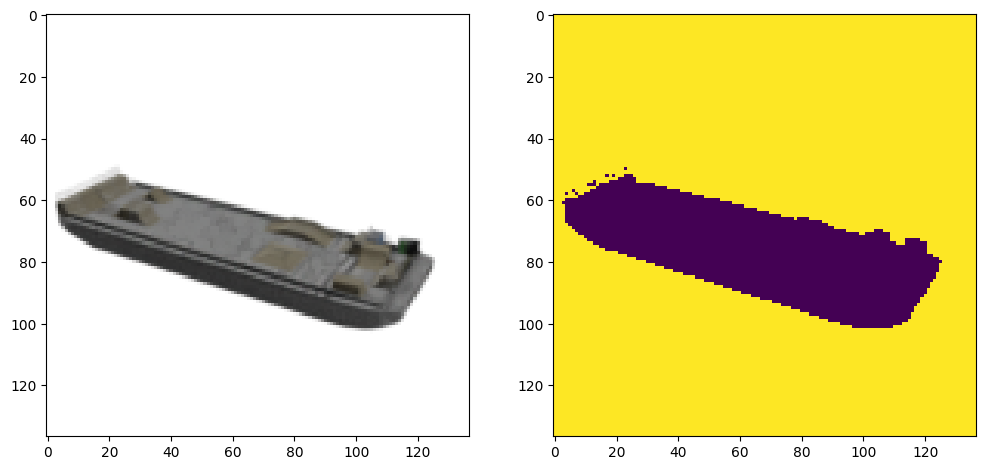

In [8]:
indx = 0
indx_view = 0

img, depth = h5_data['pixels'][indx, indx_view], h5_data['depths'][indx, indx_view]

fig = plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(img)

plt.subplot(122)
plt.imshow(depth)

In [9]:
depth_background_mask = depth > 1_000
depth_object_mask = ~depth_background_mask
depth_object_values = depth[depth_object_mask]
depth[depth_object_mask] = (depth[depth_object_mask] - depth_object_values.mean()) / (depth_object_values.std() + 1e-8)
depth[depth_background_mask] = depth[depth_object_mask].max()

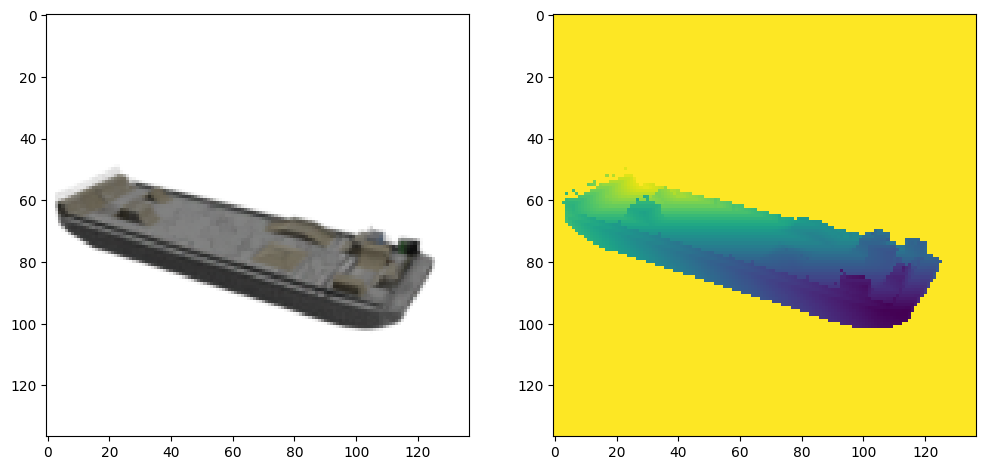

In [10]:
fig = plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(img)

plt.subplot(122)
plt.imshow(depth)

In [11]:
depth.mean(), depth.std(), depth.max(),  depth.min(), 

(2.1494443, 1.0437427, 2.5788114, -1.7477678)

In [12]:
depth[40, 40], depth[60, 60], depth[80, 120]

(array([2.5788114], dtype=float32),
 array([2.5788114], dtype=float32),
 array([-0.46683672], dtype=float32))

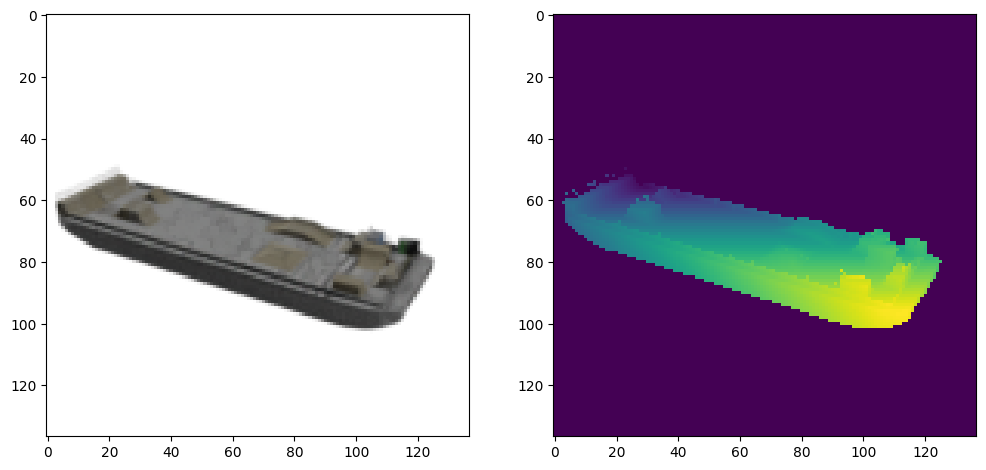

In [13]:
fig = plt.figure(figsize=(12,12))
plt.subplot(121)
plt.imshow(img)

plt.subplot(122)
plt.imshow(-depth)

In [17]:
plt.imshow(img_t[..., -1:])

NameError: name 'img_t' is not defined

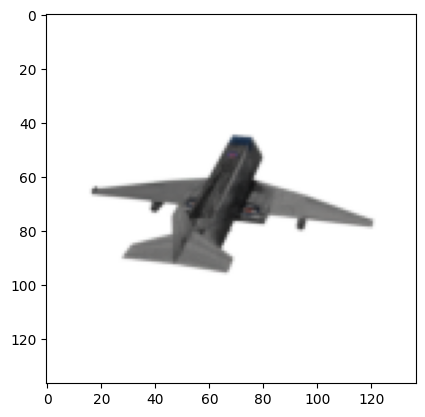

In [18]:
img_t = img.copy()
img_t *=(img_t[:, :, -1] > 0)[:, :, None] 
img_t += img_t * (img_t[:, :, -1] < 0)[:, :, None] * 255

plt.imshow(img_t)


In [20]:
-depth.mean(), -depth.std(), -depth.max(),  -depth.min(), 

(-1.5387259, -0.57579166, -1.6944581, 1.8425188)

In [21]:
depth.mean(), depth.std(), depth.max(),  depth.min(), 

(1.5387259, 0.57579166, 1.6944581, -1.8425188)

In [22]:
h5_data['pixels'].shape, h5_data['depths'].shape

((4045, 24, 137, 137, 4), (4045, 24, 137, 137, 1))

In [ ]:
for i in range(h5_data['pixels'].shape[0]):
    if i % 5_000 == 0 and i > 1 :
        print(i)
    for i_v in range(24):
        depth = h5_data['depths'][i, i_v]
        depth_background_mask = depth > 1_000
        depth_object_mask = ~depth_background_mask
        depth_object_values = depth[depth_object_mask]
        depth[depth_object_mask] = (depth[depth_object_mask] - depth_object_values.mean()) / (depth_object_values.std() + 1e-8)
        depth[depth_background_mask] = depth[depth_object_mask].max()

In [9]:
img, depth = h5_data['pixels'][i, i_v], h5_data['depths'][i, i_v]
depth_background_mask = depth > 1_000
depth_object_mask = ~depth_background_mask
depth_object_values = depth[depth_object_mask]
depth[depth_object_mask] = (depth[depth_object_mask] - depth_object_values.mean()) / (depth_object_values.std() + 1e-8)
depth[depth_background_mask] = depth[depth_object_mask].max()